In [16]:
from collections import defaultdict

import pandas as pd
import os
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

BASE_PATH = "../../data_for_classification"

# Truth direction

In [23]:
folder_path = "./activations/activations_trivia_1000_4000_right/layer_12"  
#folder_path = "/workspace/arnau/truth_analysis/activations/activations_trivia_0_1000_right/layer_12"
activation_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")])
activations_list_true = [torch.load(os.path.join(folder_path, f), map_location='cpu').cpu().numpy() for f in activation_files]

folder_path = "./activations/activations_trivia_1000_4000_wrong/layer_12"
#folder_path = "/workspace/arnau/truth_analysis/activations/activations_trivia_0_1000_wrong/layer_12"  
activation_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")])
activations_list_false = [torch.load(os.path.join(folder_path, f), map_location='cpu').cpu().numpy() for f in activation_files]

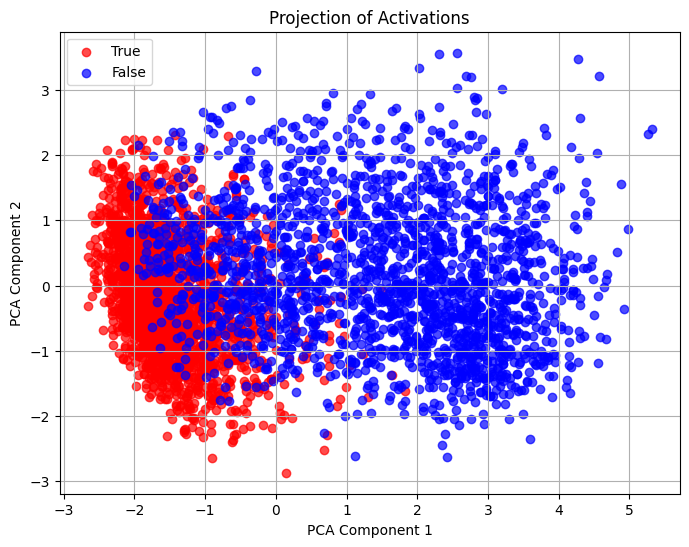

In [25]:
flat_list1 = [activations_list_true[i][j]  for i in range(len(activations_list_true)) for j in range(len(activations_list_true[i]))][:2000]
flat_list2 = [activations_list_false[i][j]  for i in range(len(activations_list_false)) for j in range(len(activations_list_false[i]))][:2000]

# Stack all data for PCA
all_data = np.vstack(flat_list1 + flat_list2)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(all_data)

# Split back into two groups
split_index = len(flat_list1)
data1_pca = transformed_data[:split_index]
data2_pca = transformed_data[split_index:]

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(data1_pca[:, 0], data1_pca[:, 1], color='red', label='True', alpha=0.7)
plt.scatter(data2_pca[:, 0], data2_pca[:, 1], color='blue', label='False', alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Projection of Activations")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
true_train = flat_list1[:int(len(flat_list1)*0.8)]
true_test = flat_list1[int(len(flat_list1)*0.8):]
false_train = flat_list2[:int(len(flat_list2)*0.8)]
false_test = flat_list2[int(len(flat_list2)*0.8):]
all_data_train = np.vstack(true_train + false_train)
all_data_test = np.vstack(true_test + false_test)

In [27]:
mean = np.mean(all_data_train, axis=0)
mean_true = np.mean(true_train, axis=0) - mean
mean_false = np.mean(false_train, axis=0) - mean
dir = mean_true - mean_false

In [28]:
# Compute accuracy of direction classifier on test data
true_test_centered = true_test - mean
false_test_centered = false_test - mean
true_scores = np.dot(true_test_centered, dir)
false_scores = np.dot(false_test_centered, dir)
true_correct = np.sum(true_scores > 0)
false_correct = np.sum(false_scores < 0)
accuracy_true = true_correct / len(true_test)
accuracy_false = false_correct / len(false_test)
print(f"Accuracy True: {accuracy_true}")
print(f"Accuracy False: {accuracy_false}")
accuracy = (true_correct + false_correct) / (len(true_test) + len(false_test))
print(f"Overall Accuracy: {accuracy}")

Accuracy True: 0.9625
Accuracy False: 0.815
Overall Accuracy: 0.88875


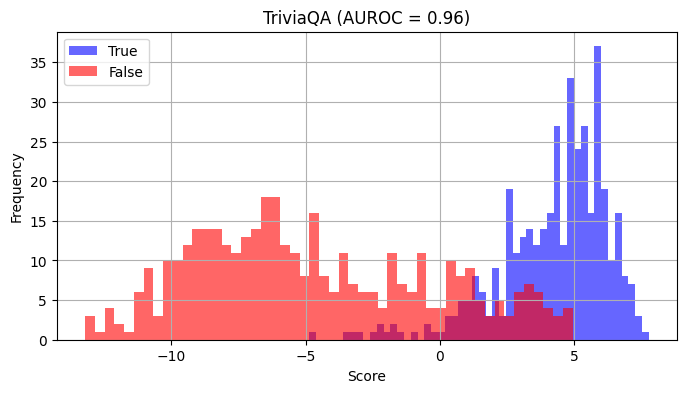

In [29]:
scores = np.concatenate([true_scores, false_scores])
labels = np.concatenate([np.ones_like(true_scores), np.zeros_like(false_scores)])
roc_auc = roc_auc_score(labels, scores)

# Plot distributions
plt.figure(figsize=(8, 4))
plt.hist(true_scores, bins=50, alpha=0.6, color='blue', label='True')
plt.hist(false_scores, bins=50, alpha=0.6, color='red', label='False')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'TriviaQA (AUROC = {roc_auc:.2f})')
plt.legend()
plt.grid()
plt.show()

### Test set

In [34]:
flat_list1_test = [activations_list_true[i][j]  for i in range(len(activations_list_true)) for j in range(len(activations_list_true[i]))][2000:2500]
flat_list2_test = [activations_list_false[i][j]  for i in range(len(activations_list_false)) for j in range(len(activations_list_false[i]))][2000:2500]
true_test = flat_list1_test
false_test = flat_list2_test
true_test_centered = true_test - mean
false_test_centered = false_test - mean
true_scores = np.dot(true_test_centered, dir)
false_scores = np.dot(false_test_centered, dir)
true_correct = np.sum(true_scores >= 0.6)
false_correct = np.sum(false_scores < 0.6)
accuracy_true = true_correct / len(true_test)
accuracy_false = false_correct / len(false_test)
print(f"Accuracy True: {accuracy_true}")
print(f"Accuracy False: {accuracy_false}")
accuracy = (true_correct + false_correct) / (len(true_test) + len(false_test))
print(f"Overall Accuracy: {accuracy}")
scores = np.concatenate([true_scores, false_scores])
labels = np.concatenate([np.ones_like(true_scores), np.zeros_like(false_scores)])
roc_auc = roc_auc_score(labels, scores)
print(f"ROC AUC: {roc_auc}")

Accuracy True: 0.958
Accuracy False: 0.84
Overall Accuracy: 0.899
ROC AUC: 0.96338


### Cities data on TriviaQA train

In [10]:
# df = pd.read_csv("/workspace/arnau/truth_analysis/prompts/cities_rephrased.csv")
# df_true = df[df["label"] == 1]
# df_false = df[df["label"] == 0]
# df_true['prompt'] = df_true['statement_rephrased']
# df_false['prompt'] = df_false['statement_rephrased']
# # Save csv
# df_true[['prompt']].to_csv("/workspace/arnau/truth_analysis/prompts/cities_longer_true.csv", index=False)
# df_false[['prompt']].to_csv("/workspace/arnau/truth_analysis/prompts/cities_longer_false.csv", index=False)

In [11]:
folder_path = "./activations/activations_cities_right/layer_12"  
activation_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")])
activations_list_true_test = [torch.load(os.path.join(folder_path, f), map_location='cpu').cpu().numpy() for f in activation_files]

folder_path = "./activations/activations_cities_wrong/layer_12"  
activation_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")])
activations_list_false_test = [torch.load(os.path.join(folder_path, f), map_location='cpu').cpu().numpy() for f in activation_files]

In [12]:
flat_list1_test = [activations_list_true_test[i][j]  for i in range(len(activations_list_true_test)) for j in range(len(activations_list_true_test[i]))]
flat_list2_test = [activations_list_false_test[i][j]  for i in range(len(activations_list_false_test)) for j in range(len(activations_list_false_test[i]))]

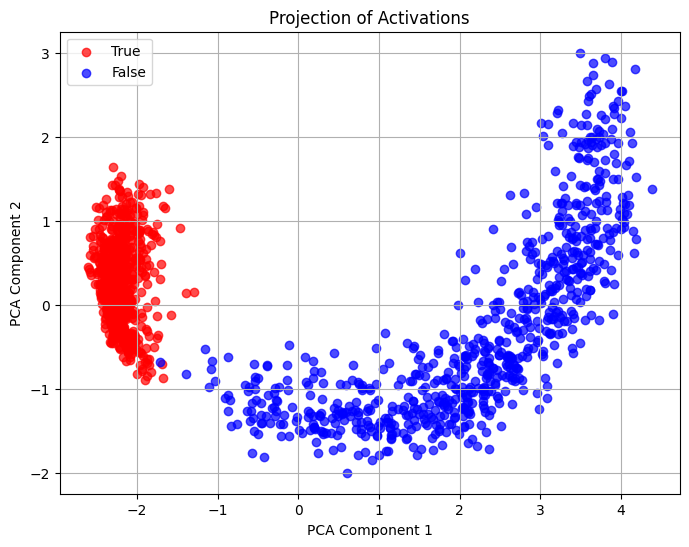

In [13]:
# Stack all data for PCA
all_data = np.vstack(flat_list1_test + flat_list2_test)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(all_data)

# Split back into two groups
split_index = len(flat_list1_test)
data1_pca = transformed_data[:split_index]
data2_pca = transformed_data[split_index:]

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(data1_pca[:, 0], data1_pca[:, 1], color='red', label='True', alpha=0.7)
plt.scatter(data2_pca[:, 0], data2_pca[:, 1], color='blue', label='False', alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Projection of Activations")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Compute accuracy of direction classifier on test data
true_test = flat_list1_test
false_test = flat_list2_test
true_test_centered = true_test - mean
false_test_centered = false_test - mean
true_scores = np.dot(true_test_centered, dir)
false_scores = np.dot(false_test_centered, dir)
true_correct = np.sum(true_scores > 0)
false_correct = np.sum(false_scores < 0)
accuracy_true = true_correct / len(true_test)
accuracy_false = false_correct / len(false_test)
print(f"Accuracy True: {accuracy_true}")
print(f"Accuracy False: {accuracy_false}")
accuracy = (true_correct + false_correct) / (len(true_test) + len(false_test))
print(f"Overall Accuracy: {accuracy}")

Accuracy True: 1.0
Accuracy False: 0.8943850267379679
Overall Accuracy: 0.9471925133689839


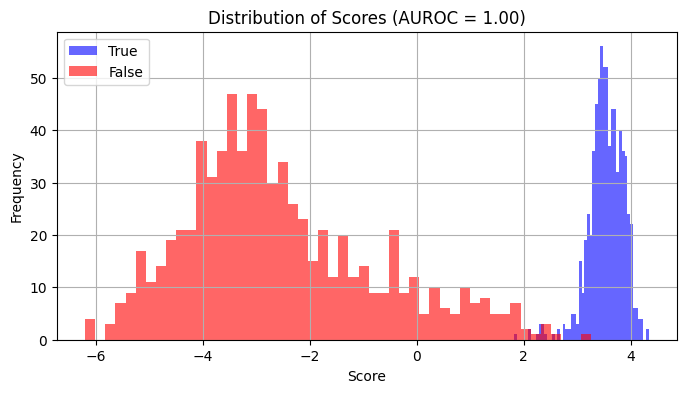

In [17]:
scores = np.concatenate([true_scores, false_scores])
labels = np.concatenate([np.ones_like(true_scores), np.zeros_like(false_scores)])
roc_auc = roc_auc_score(labels, scores)

# Plot distributions
plt.figure(figsize=(8, 4))
plt.hist(true_scores, bins=50, alpha=0.6, color='blue', label='True')
plt.hist(false_scores, bins=50, alpha=0.6, color='red', label='False')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scores (AUROC = {roc_auc:.2f})')
plt.legend()
plt.grid()
plt.show()

# Correctness direction